# Predicting Protein Functions

## Data Preprocessing

In [44]:
import re # regular expression
import os  #operating system
import glob 
import json

In [34]:
#making dataset path universal for all operating systems
scrape_dir = os.path.join("/kaggle/input/protein-dataset")
print(scrape_dir)

/kaggle/input/protein-dataset


In [35]:
import datetime , time   # to keep track of files created

ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime("%Y-%m-%d-%H%M%S")

print("Converting Sequences")

# Define the directory and ensure it exists
output_dir = os.path.join("/kaggle/working")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Construct the output file path
out_file = os.path.join(output_dir, f"protein-seqs-{st}.txt")
print(f"Writing to: {out_file}")

Converting Sequences
Writing to: /kaggle/working/protein-seqs-2024-06-24-190318.txt


In [36]:
num_proteins_done = 0   # TODO: Remove (here to reduce complexity)

# All files are read like this: 
fasta_files = glob.glob(scrape_dir + "/*.fasta") #searcing all fasta files
print(fasta_files)

['/kaggle/input/protein-dataset/all-human-0001.fasta']


In [37]:
#helper function
def dump_to_file(protein_id , sequence):
    with open (out_file,"a") as f:
        f.write(protein_id + "," + sequence + "\n")  #writes protein id and sequence into the text file

In [38]:
for fname in fasta_files:
    print("Converting: %s" % fname)

    with open (fname , "r") as f:
        protein_seq = ''
        protein_id = ''

        for line in f:
            
            # matching the sequence >[two character]|[alphanumeric chars]|[other stuff]
            match = re.search(r'^>([a-z]{2})\|([A-Z0-9]*)\|', line)
            if match:

                if protein_id != '':
                    dump_to_file(protein_id,protein_seq)

                num_proteins_done +=1
                if num_proteins_done > 10000: break  #extracting 10,000 proteins only


                # starting a new sequence 
                protein_id = match.group(2)  # group 2 is ([A-Z0-9]*) which is the protein sequence
                protein_seq = ''   


            else:
                protein_seq += line.strip() # appending  the protein sqnce , strip() for any empty spaces
                
                
        if protein_id != '':
            dump_to_file(protein_id , protein_seq)

Converting: /kaggle/input/protein-dataset/all-human-0001.fasta


In [39]:
# separating proteins with 00005524 ATP binding
print("Converting function")
#file to store proteins doing ATP
output_file_fns = os.path.join("/kaggle/working" , "protein-functions-" + st + ".txt")

print(output_file_fns)

target_function = ['0005524']  # ATP binding function

Converting function
/kaggle/working/protein-functions-2024-06-24-190318.txt


In [40]:
annot_files = glob.glob(scrape_dir + "/*annotations.txt")
print(annot_files)

['/kaggle/input/protein-dataset/all-human-0001-annotations.txt']


In [41]:
has_function = []
for fname in annot_files:
    with open(fname , "r") as f:
        for line in f:
            match = re.search(r'([A-Z0-9]*)\sGO:(.*);\sF:.*;', line)

            if match:
                # getting the match
                protein_id = match.group(1)
                function = match.group(2)


                if function not in target_function:
                    continue

                has_function.append(protein_id)

   
    with open(output_file_fns,"w") as fp:
        json.dump(has_function,fp)


    # look at the hash_function
    print(has_function[:10])

['P27361', 'P53779', 'Q9UHC1', 'Q9NYL2', 'O15440', 'P33527', 'Q92887', 'O15438', 'O15439', 'Q5T3U5']


## Loading Data and Getting the Shapes Right

In [173]:
import numpy as np
np.random.seed(1337)

import json
import os

from keras.preprocessing import sequence
import warnings
warnings.filterwarnings('ignore')

In [48]:
sequence_file = os.path.join("/kaggle/working","protein-seqs-2024-06-24-190318.txt")
functions_file = os.path.join("/kaggle/working","protein-functions-2024-06-24-190318.txt")

In [54]:
with open(functions_file) as fn_file:
    has_function = json.load(fn_file)

In [55]:
max_sequence_size = 500  #maximum size sequence is 500 , other than that are ignored

In [56]:
X = []  #sequences
Y = []  #output class: 1 if protein has function , 0 if not

In [57]:
# for seeing how many example we have found for each class
pos_examples = 0
neg_examples = 0

In [58]:
with open(sequence_file) as f:
    for line in f:
        ln = line.split(',')
        protein_id = ln[0].strip()
        seq = ln[1].strip()

        if len(seq) >= max_sequence_size:
            continue

        #print(line)

        X.append(seq)

        if protein_id in has_function:
            Y.append(1)
            pos_examples += 1
        else:
            Y.append(0)
            neg_examples += 1

In [59]:
print("Positive Examples: ",pos_examples)
print("Negative Examples: ",neg_examples)

Positive Examples:  220
Negative Examples:  5765


In [60]:
def sequence_to_indices(sequence):
    
    
        #Converting amino acids alphabet to numerics , '_' character represents no amino acid (for the purpose of padding) """
    try:
        acid_letters = ['_','A','C','D','E','F','G','H','I','K',
                        'L','M','N','P','Q','R','S','T','U','V','W','Y','Z']
        indices = [acid_letters.index(c) for c in list(sequence)]
        return indices
    except Exception:
        print(sequence)
        raise Exception

In [61]:
X_all = []  # for storing numeric values of amino acids
for i in range(len(X)):
    x = sequence_to_indices(X[i])
    X_all.append(x)

In [62]:
X_all = sequence.pad_sequences(X_all , maxlen = max_sequence_size) #padding the sequence to equal the size

In [197]:
#X_all[0]

In [63]:
#converting list to np array
X_all  = np.array(X_all)
Y_all = np.array(Y)

In [200]:
# X_all[0]

## Train ,Test and Split the Data

In [64]:
print(X_all.shape)
print(Y_all.shape)

(5985, 500)
(5985,)


In [65]:
n = X_all.shape[0]  # number of datapoints

In [66]:
# randomize to shuffle 
randomize = np.arange(n)

In [67]:
np.random.shuffle(randomize) # shuffling

In [68]:
randomize

array([1327, 2526, 3458, ...,  860,  189, 3223])

In [69]:
X_all =  X_all[randomize]   #applying the shuffling to datapoints
Y_all = Y_all[randomize]

In [70]:
test_split = round(n* 2/3) # splitting data on 2/3 ratio
X_train = X_all[:test_split] #2/3 for training of datapoints
Y_train = Y_all[:test_split]   #training labels
X_test = X_all[test_split:]  # testing datapoints
Y_test = Y_all[test_split:]  #testing labels 

In [71]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3990, 500)
(3990,)
(1995, 500)
(1995,)


## Understanding Shapes

In [72]:
"      ->>>[ .   .   .   .   .  upto 5 ]<<<-  total 5 datapoints        Initial Shape (5 , )  "

'      ->>>[ .   .   .   .   .  upto 5 ]<<<-  total 5 datapoints        Initial Shape (5 , )  '

In [73]:
""" ->>>[   ->>[ . . . . . . . . . . upto 500]<<-  []  []  []   []   ]<<<-    each datapoints has 500 elements(amino acids)

so the shape becomes    Shape: (5 , 500 ) """  

' ->>>[   ->>[ . . . . . . . . . . upto 500]<<-  []  []  []   []   ]<<<-    each datapoints has 500 elements(amino acids)\n\nso the shape becomes    Shape: (5 , 500 ) '

In [74]:
"""

->>>[   ->>[ [....23] [.....23] [....23] . . . . . . . upto 500]<<-  []  []  []   []   ]<<<-

Now  in the 5 data-points, there are 500 elements, these 500 elements are the protein vectors of size 23

we changed  each amino acid into single hot vector

The shape is now Shape: ( 5 , 500 , 23 )
"""

'\n\n->>>[   ->>[ [....23] [.....23] [....23] . . . . . . . upto 500]<<-  []  []  []   []   ]<<<-\n\nNow  in the 5 data-points, there are 500 elements, these 500 elements are the protein vectors of size 23\n\nwe changed  each amino acid into single hot vector\n\nThe shape is now Shape: ( 5 , 500 , 23 )\n'

## Setting up the Model

In [89]:
from tensorflow.keras.layers import Embedding , Input , Flatten , Dense , Activation , Conv1D , MaxPooling1D, GlobalMaxPooling1D,Dropout
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.optimizers import SGD

In [155]:
num_amino_acids = 23
embedding_dims = 10
nb_epochs = 50
batch_size = 128

In [156]:
model = Sequential()

model.add(Embedding(num_amino_acids , embedding_dims , input_shape = (max_sequence_size,)))  # we have set an embedding layer

model.add(Dense(128, activation='sigmoid'))

model.add(Dense(64, activation='sigmoid'))

model.add(Flatten()) # for combining dimensions into a single vector

model.add(Dense(25 , activation = 'sigmoid'))

model.add(Dense(1 , activation = 'sigmoid'))

In [157]:
model.compile(loss='binary_crossentropy' ,
             optimizer = SGD() ,
             metrics = ['accuracy'])

In [158]:
model.summary()  # ( None , 500 , 10 )  None represents the batch size , 500 = total amino acids , 10 is the each amino acid vector which reduced from 23 to 10

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 500, 10)        │           230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 500, 128)       │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 500, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 25)             │       800,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 809,945 (3.09 MB)

 Trainable params: 809,945 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

In [159]:
history = model.fit(X_train ,Y_train,
                    batch_size = batch_size ,
                    epochs = nb_epochs ,
                    validation_data = (X_test , Y_test) , 
                    verbose = 1 )

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.8469 - loss: 0.3568 - val_accuracy: 0.9639 - val_loss: 0.1782
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9644 - loss: 0.1749 - val_accuracy: 0.9639 - val_loss: 0.1701
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9593 - loss: 0.1805 - val_accuracy: 0.9639 - val_loss: 0.1655
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9614 - loss: 0.1715 - val_accuracy: 0.9639 - val_loss: 0.1625
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9642 - loss: 0.1612 - val_accuracy: 0.9639 - val_loss: 0.1606
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9580 - loss: 0.1769 - val_accuracy: 0.9639 - val_loss: 0.1593
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9664 - loss: 0.1520 - val_accuracy: 0.9639 - val_loss: 0.1583
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9632 - loss: 0.1602 - val_accuracy: 0.

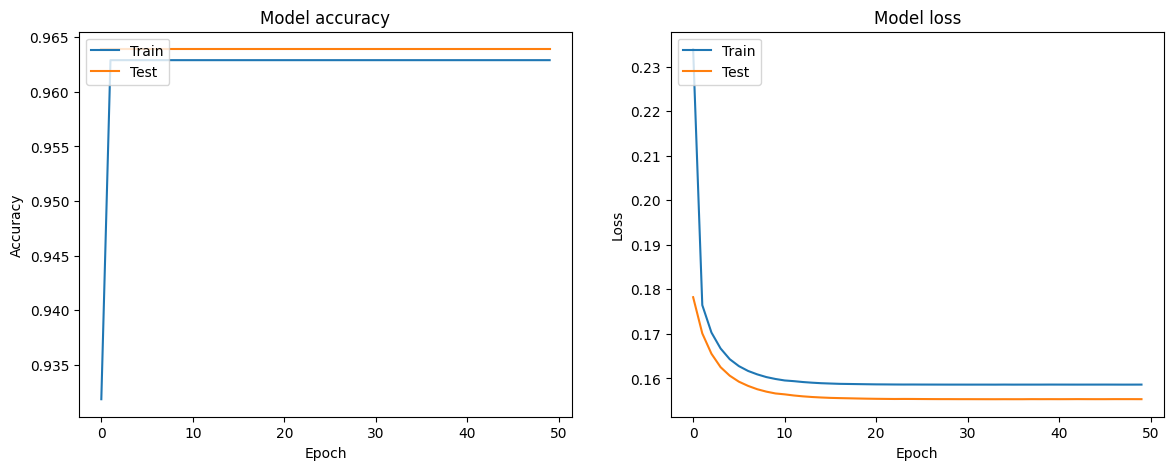

In [160]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

## Changing Sequential Model to Functional API

In [161]:
#each layer is turned into a function
input = Input(shape = (max_sequence_size , ))

In [162]:
embedding = Embedding(num_amino_acids , embedding_dims)(input) #the input is passed to the embedding layer  

In [163]:
x = Dense(128, activation='sigmoid')(embedding)
x = Dense(64, activation='sigmoid')(x)
x = Flatten()(x)   # takes output of emebedding layer and pass it to the flatten layer
x = Dense(25 , activation = 'sigmoid')(x)  # passing flatten output to the dense layer
x = Dense(1)(x)
# the layers above are intermediate layer

In [164]:
output = Activation('sigmoid')(x)

In [165]:
model = Model([input], output)  #input and output is passed to the model

In [166]:
model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_19 (Embedding)        │ (None, 500, 10)        │           230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 500, 128)       │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 500, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 25)             │       800,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1)              │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 809,945 (3.09 MB)

 Trainable params: 809,945 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

In [167]:
model.compile(loss = 'binary_crossentropy' , 
             optimizer = 'Adam' ,
              metrics = ['accuracy']
             )

In [168]:
history = model.fit(X_train , Y_train , 
         batch_size = batch_size ,
         epochs = nb_epochs ,
         validation_data = (X_test , Y_test) ,
         verbose = 1)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9624 - loss: 0.2229 - val_accuracy: 0.9639 - val_loss: 0.1560
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9662 - loss: 0.1479 - val_accuracy: 0.9639 - val_loss: 0.1556
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9634 - loss: 0.1572 - val_accuracy: 0.9639 - val_loss: 0.1554
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9648 - loss: 0.1525 - val_accuracy: 0.9639 - val_loss: 0.1553
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9654 - loss: 0.1504 - val_accuracy: 0.9639 - val_loss: 0.1553
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9588 - loss: 0.1720 - val_accuracy: 0.9639 - val_loss: 0.1553
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9610 - loss: 0.1646 - val_accuracy: 0.9639 - val_loss: 0.1553
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9652 - loss: 0.1513 - val_accuracy: 0.

In [172]:
# history.history

In [170]:
import matplotlib.pyplot as plt

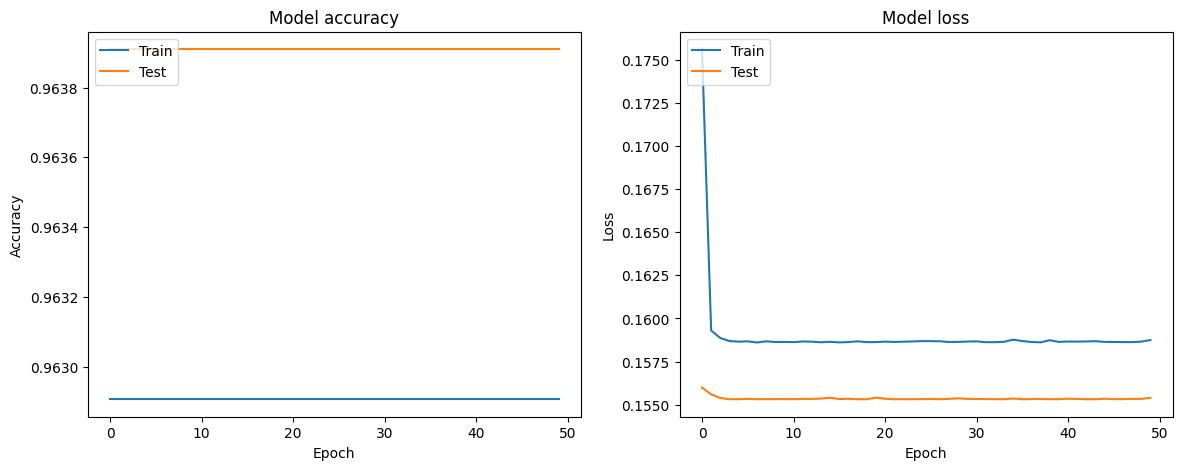

In [171]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()